# Ellipse calculations

## Imports

In [1]:
# Python standard library
import sys
import csv


# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.interpolate


# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load video and events

In [6]:
date = '8-9-2017/'
particle = 'HCT-116'
channel = '15-30-15_5/'
file_index = '0/'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index.replace('/','')
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index.replace('/','') + '_events.json'


res_x = 512
res_y = 288
fps = 100000
exposure_time = 5*10**(-6.)

In [7]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, fps)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

IOError: [Errno 2] No such file or directory: '/home/prestonh/Desktop/Research/cancer_cells/data/8-9-2017/HCT-11615-30-15_5/oi/bin/test_camera_0'

## Output

In [7]:
save_base_path = '/home/prestonh/Desktop/Research/cancer_cells/analysis/data/' + date + particle + channel + file_index + 'calculations/'

print save_base_path

/home/prestonh/Desktop/Research/cancer_cells/analysis/data/7-7-2017/293-T/17p5-35-17p5_0/0/calculations/


In [8]:
def save_list(lst, feature_name, note = None):
    # Open file for writing
    with open(save_base_path + feature_name, 'w') as file_handle:
        
        # Create writer
        file_writer = csv.writer(file_handle, delimiter = '\t')
        
        if note:
            file_writer.writerow([note])
        
        # Loop over list of lists
        for ele in lst:
            file_writer.writerow([ele])

def save_list_of_lists(list_of_lists_1, list_of_lists_2, feature_name, note = None):
    
    # Open file for writing
    with open(save_base_path + feature_name, 'w') as file_handle:
        
        # Create writer
        file_writer = csv.writer(file_handle, delimiter = '\t')
        
        if note:
            file_writer.writerow([note])
        
        # Loop over list of lists
        for i in range(len(list_of_lists_1)):

            list_1 = list_of_lists_1[i]
            list_2 = list_of_lists_2[i]

            # Indicate new event line
            file_writer.writerow(['event #', i])
            
            # Loop over list
            for j in range(len(list_1)):
                file_writer.writerow([list_1[j], list_2[j]])
                    

# Create stage

[ 0.01886457  0.99982205]


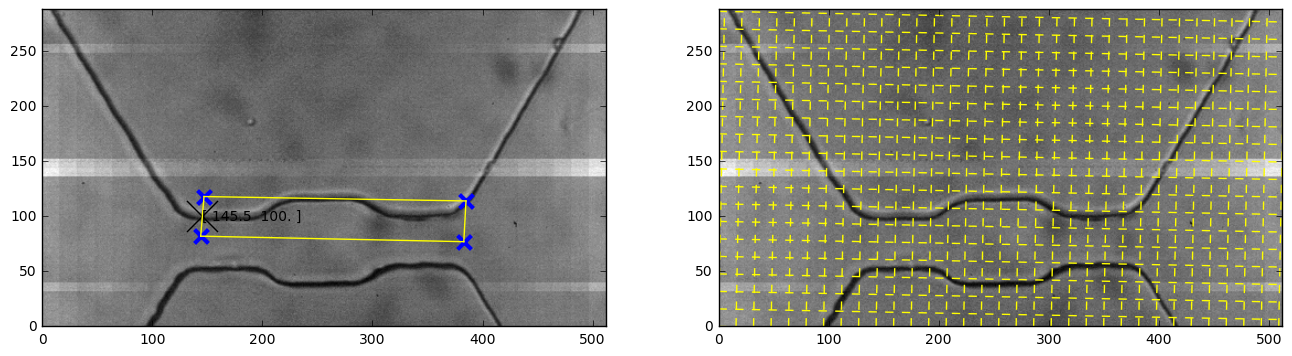

In [10]:
reload(oi)
template_index = 90
template_frame = oi_vid.get_frame(template_index)
c0 = [144, 82]
c1 = [147, 118]
c2 = [385, 114] 
c3 = [383, 77]


oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Load ellipses

In [8]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + date + particle + channel + file_index + 'ellipses'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

## Filter

In [9]:
# Load keep indices
filter_file_path = '../data/' + date + particle + channel + file_index + 'filter'

with open(filter_file_path, 'r') as filter_file_handle:
    filter_file_reader = csv.reader(filter_file_handle, delimiter = '\t')
    for row in filter_file_reader:
        if row[0] == 'events':
            keep_indices = [int(ele) for ele in row[1:]]

print 'loaded keep indices (', len(keep_indices), 'events total):\n', keep_indices

loaded keep indices ( 26 events total):
[1, 7, 16, 17, 18, 25, 30, 32, 34, 39, 41, 52, 59, 63, 65, 68, 76, 77, 78, 79, 81, 82, 87, 90, 94, 95]


In [10]:
filtered_oi_events = [oi_events[i] for i in range(len(oi_events)) if i in keep_indices]
filtered_ellipsess = [ellipsess[i] for i in range(len(ellipsess)) if i in keep_indices]

oi_events = filtered_oi_events
ellipsess = filtered_ellipsess

## Begin calculations

In [18]:
oi_index = 0
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf, fps).to_html5_video())

### Aspect ratio

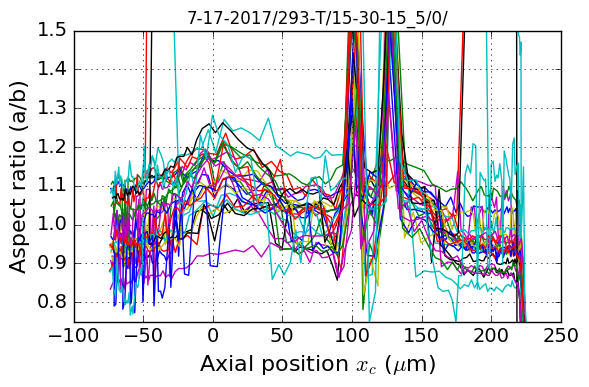

In [28]:
feature_name = 'aspects'
note = 'aspect (a/b) versus channel position (microns)'

xcss = []
aspectss = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    ts = []
    xcs = []
    aspects = []
    
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        tf = oi_event._detections[int(ellipse[0])]._tf
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Get ellipse axes
        L_a = ellipse[3]
        L_b = ellipse[4]
        
        # Convert to microns
        L_a = oi_stage.pixels_to_meters(L_a)
        L_b = oi_stage.pixels_to_meters(L_b)
        
        '''
        # Get ellipse angle
        angle = ellipse[5]
        
        
        # Convert to vectors
        ellipse_a = np.array([np.cos(angle), np.sin(angle)])*L_a
        ellipse_b = np.array([np.sin(angle), -np.cos(angle)])*L_b
        
        # Change to stage coordinates
        ellipse_a_c = np.array([np.dot(ellipse_a, oi_stage._norm_x), \
                                       np.dot(ellipse_a, oi_stage._norm_y)])
        
        ellipse_b_c = np.array([np.dot(ellipse_b, oi_stage._norm_x), \
                                       np.dot(ellipse_b, oi_stage._norm_y)])
        
        # Change to microns
        ellipse_a_c = oi_stage.pixels_to_meters(ellipse_a_c)
        ellipse_b_c = oi_stage.pixels_to_meters(ellipse_b_c)
        '''
     
        # Append to list
        xcs.append(xc)
        aspects.append(L_a/L_b)
    
    # Plot event
    plt.plot(xcs, aspects)
    
    # Append list to list of lists
    xcss.append(xcs)
    aspectss.append(aspects)
    

# Range
plt.ylim(0.75, 1.5)
    
# Cosmetics
plt.title(date + particle + channel + file_index)

plt.xlabel(r'Axial position $x_{c}$ ($\mu$m)', size = 16)
plt.ylabel(r'Aspect ratio (a/b)', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()

plt.tight_layout()

# Save plot
plt.savefig(save_base_path + feature_name + '_plot.png', dpi = 100, )

plt.show()



# Save data
save_list_of_lists(xcss, aspectss, feature_name, note)

## Velocity

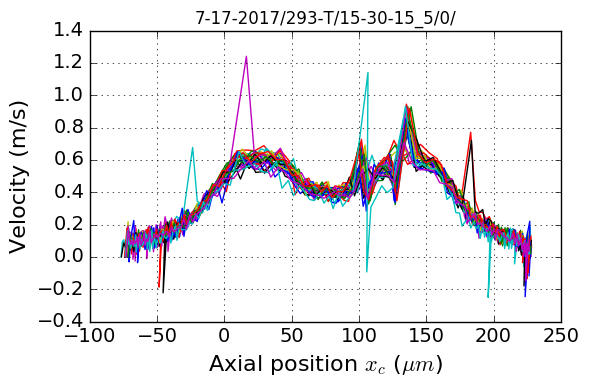

In [22]:
feature_name = 'velocity'
note = 'velocity (m/s) versus channel position (microns)'

tss = []
xcss = []
xc_velocitiess = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    
    
    ts = []
    xcs = []
    xc_velocities = []
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        tf = oi_event._detections[int(ellipse[0])]._tf
        t = 1.*tf/fps
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Calculate velocity
        if j > 0:
            xc_velocity = (xc - xcs[-1])/(t-ts[-1])*10**(-6.)
        else:
            xc_velocity = 0

                
        
        # Append to list
        ts.append(t)
        xcs.append(xc)
        xc_velocities.append(xc_velocity)
    
        
        
    # Append list to list of lists
    tss.append(ts)
    xcss.append(xcs)
    xc_velocitiess.append(xc_velocities)
        
    # Plot event
    plt.plot(xcs, xc_velocities)
    
# Cosmetics
plt.title(date + particle + channel + file_index)


plt.xlabel(r'Axial position $x_{c}$ ($\mu m$)', size = 16)
plt.ylabel(r'Velocity (m/s)', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()
    
plt.tight_layout()

# Save plot
plt.savefig(save_base_path + feature_name + '_plot.png', dpi = 100, )

plt.show()


# Save data
save_list_of_lists(xcss, xc_velocitiess, feature_name, note)

## Blur

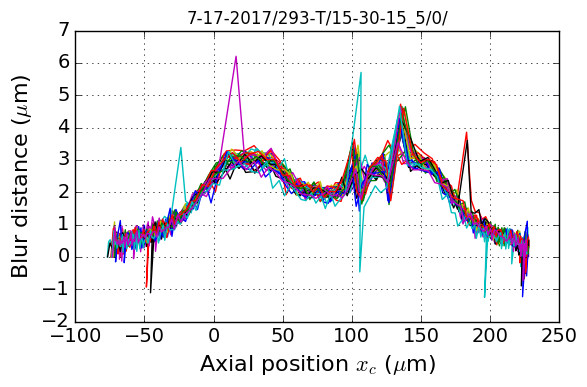

In [23]:
feature_name = 'blur'
note = 'Calculated blur at each position based on velocity and exposure rate (all in microns)'

tss = []
xcss = []
xc_velocitiess = []
blurss = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    
    # Create empty lists to store event data
    ts = []
    xcs = []
    xc_velocities = []
    blurs = []
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        tf = oi_event._detections[int(ellipse[0])]._tf
        t = 1.*tf/fps
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Calculate velocity
        if j > 0:
            xc_velocity = (xc - xcs[-1])/(t-ts[-1])*10**(-6.)
        else:
            xc_velocity = 0
            
        # Calculate blur
        blur = xc_velocity * exposure_time * 10**(6.)

                
        
        # Append to list
        ts.append(t)
        xcs.append(xc)
        xc_velocities.append(xc_velocity)
        blurs.append(blur)
    
        
        
    # Append list to list of lists
    tss.append(ts)
    xcss.append(xcs)
    xc_velocitiess.append(xc_velocities)
    blurss.append(blurs)
        
    # Plot event
    plt.plot(xcs, blurs)
    
# Cosmetics
plt.title(date + particle + channel + file_index)


plt.xlabel(r'Axial position $x_{c}$ ($\mu$m)', size = 16)
plt.ylabel(r'Blur distance ($\mu$m)', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()

plt.tight_layout()

# Save plot
plt.savefig(save_base_path + feature_name + '_plot.png', dpi = 100, )

plt.show()


# Save data
save_list_of_lists(xcss, xc_velocitiess, feature_name, note)

## Particle radius

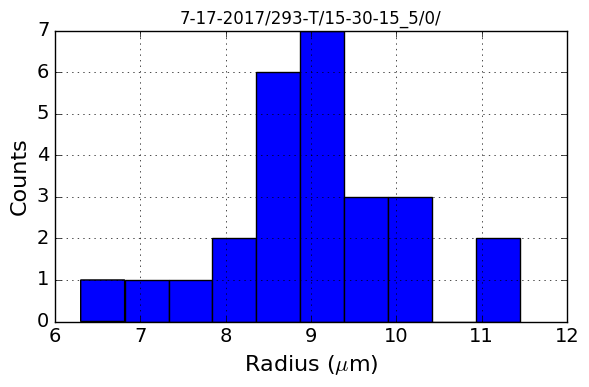

In [24]:
feature_name = 'radius'
note = 'Calculated radius of each particle based off of frame when particle is outside channel'

radii = []

# Loop over events
for i, oi_event in enumerate(oi_events):
    ellipses = ellipsess[i]
    
    
    # Create empty lists to store event data
    xcs = []
    event_radii = []
    
    # Loop over ellipses within event
    for j, ellipse in enumerate(ellipses):
        
        # Get ellipse position
        x = ellipse[1]
        y = ellipse[2]
        
        # Convert to channel units
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        
        # Convert to microns
        xc = oi_stage.pixels_to_meters(xc)
        
        # Get ellipse axes lengths
        a = ellipse[3]
        b = ellipse[4]
        
        
        
        # Get average radius
        avg_radius = np.sqrt(a*b)
        
        
        # Convert average radius to micron
        avg_radius = oi_stage.pixels_to_meters(avg_radius)
    

        # Append to list
        xcs.append(xc)
        event_radii.append(avg_radius)
        

    # Convert arrays to numpy
    xcs = np.array(xcs)
    event_radii = np.array(event_radii)
    

    
    # Get index where particle is out of channel
    xc_left = -30
    xc_right = -10
    radius = event_radii[(xcs > xc_left) & (xcs < xc_right)][0]
    
    
    # Append to list
    radii.append(radius)
    
        
# Plot event
plt.hist(radii)
    
# Cosmetics
plt.title(date + particle + channel + file_index)


plt.xlabel(r'Radius ($\mu$m)', size = 16)
plt.ylabel(r'Counts', size = 16)

plt.tick_params(labelsize = 14)

plt.grid()

plt.tight_layout()

# Save plot
plt.savefig(save_base_path + feature_name + '_plot.png', dpi = 100, )

plt.show()


# Save data
save_list(radii, feature_name, note)